Data Loading and Processing Tutorial
====================================

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv'); landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
5,137341995_e7c48e9a75.jpg,-4,129,1,178,10,231,30,276,59,...,204,238,260,241,210,281,188,286,166,286
6,1383023626_8a49e4879a.jpg,0,48,-6,94,-10,141,-8,186,6,...,165,233,194,230,163,263,145,268,128,265
7,144044282_87cf3ff76e.jpg,122,104,121,116,121,129,122,142,125,...,165,154,178,154,164,153,159,154,154,153
8,152601997_ec6429a43c.jpg,109,66,108,98,111,132,118,169,127,...,205,216,239,220,208,216,197,217,187,216
9,1549040388_b99e9fa295.jpg,149,89,139,123,136,159,139,195,146,...,231,238,292,243,232,251,212,248,196,242


In [5]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='y')
    plt.pause(0.001)  # pause a bit so that plots are updated

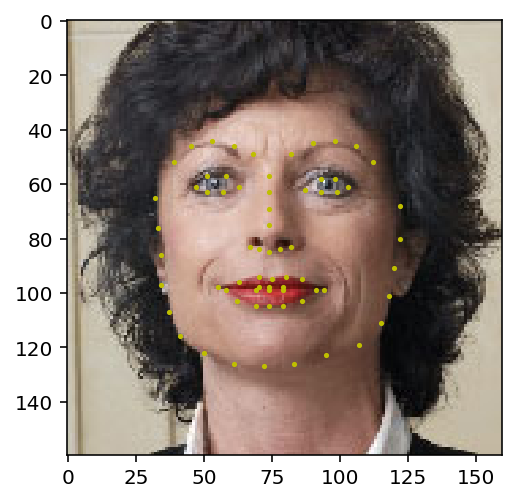

In [6]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$ th sample

In [7]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)
        return sample

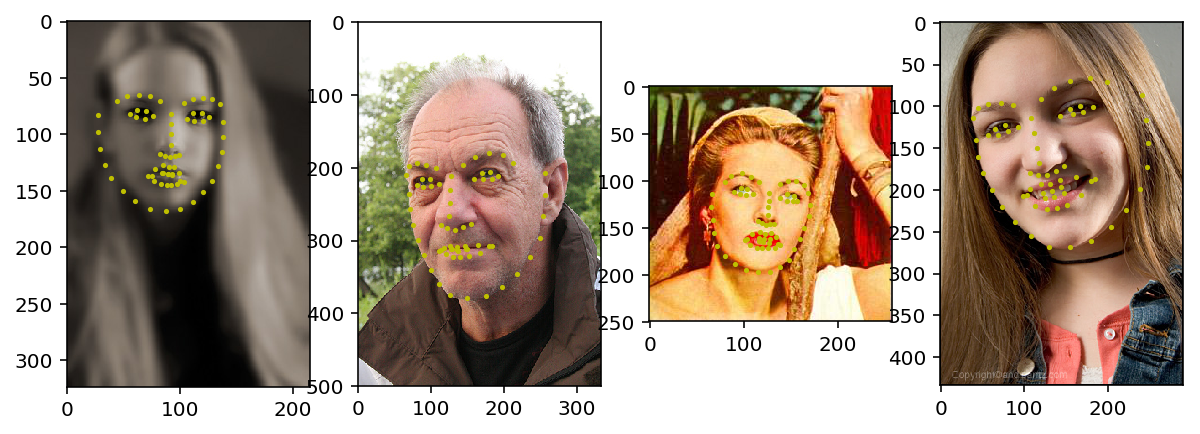

In [8]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')
plt.figure(figsize=(10,20))
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    plt.subplot(1,4, i + 1)
    plt.imshow(sample['image'])
    plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], s=10, marker='.', c='y')
    if i == 3: break

Transforms
----------

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. 

Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. 

In [65]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Let's say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.

``torchvision.transforms.Compose`` is a simple callable class which allows us
to do this.




(256, 256, 3)
(128, 128, 3)
(224, 224, 3)


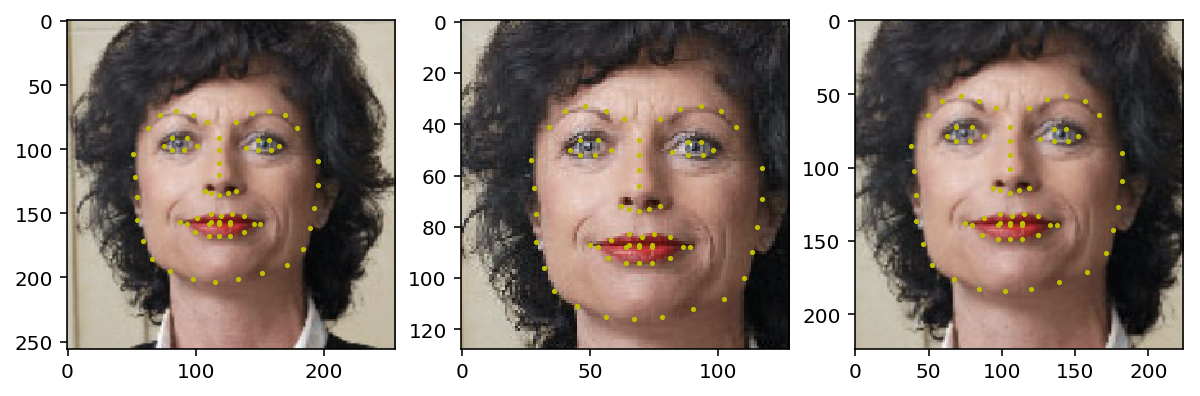

In [79]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure(figsize=(10,20))
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    print(transformed_sample['image'].shape)
    plt.imshow(transformed_sample['image'])
    plt.scatter(transformed_sample['landmarks'][:, 0], transformed_sample['landmarks'][:, 1], s=10, marker='.', c='y')

Iterating through the dataset
-----------------------------

Let's put this all together to create a dataset with composed
transforms.
To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before.




In [83]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3: break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


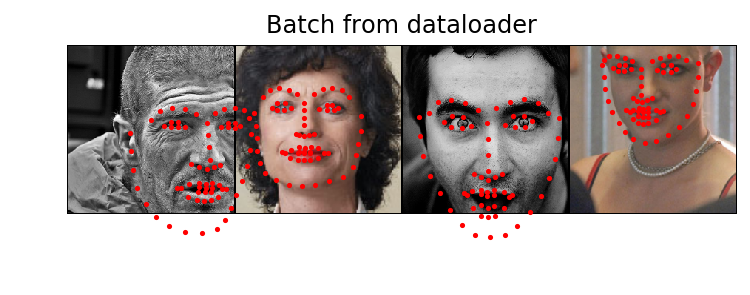

In [88]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

ImageFolder
----------------------
One of generic datasets available in torchvision is `ImageFolder`.
It assumes that images are organized in the following way

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

where 'ants', 'bees' etc. are class labels. Similarly generic transforms
which operate on ``PIL.Image`` like  ``RandomHorizontalFlip``, ``Scale``,
are also available. You can use these to write a dataloader like this.
([transfer_learning_tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html))



In [ ]:
data_transform = transforms.Compose([
      transforms.RandomSizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])])

hymenoptera_dataset = datasets.ImageFolder(root='data/hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)